# Load dataset

In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 60)
traffic = pd.read_csv("traffic_fines_1.csv", sep=';', low_memory=False)
display(traffic.head(3))
traffic.shape

,article,vehicleClass,amount,points,Case ID,Activity,Resource,lastSent,notificationType,dismissal,expense,Complete Timestamp,timesincemidnight,month,weekday,hour,timesincelastevent,timesincecasestart,event_nr,open_cases,label
0,157.0,A,35.0,0.0,A100,Create Fine,561.0,missing,missing,NIL,0.0,2006-08-02 01:00:00,60,8,2,1,0.0,0.0,1,11246,deviant
1,157.0,A,35.0,0.0,A100,Send Fine,561.0,missing,missing,NIL,11.0,2006-12-12 01:00:00,60,12,1,1,190080.0,190080.0,2,12380,deviant
2,157.0,A,35.0,0.0,A100,Insert Fine Notification,561.0,P,P,NIL,11.0,2007-01-15 01:00:00,60,1,0,1,48960.0,239040.0,3,12202,deviant


(460556, 21)

In [3]:
import EventLog as el

In [4]:
log = el.EventLog(traffic, 'Case ID', 'Complete Timestamp')

Found False


In [5]:
log.static_columns()

['article', 'vehicleClass', 'points', 'timesincemidnight', 'hour', 'label']

In [6]:
log.df.nunique()

article                   50
vehicleClass               4
amount                   204
points                     9
Case ID               129615
Activity                  10
Resource                 148
lastSent                   4
notificationType           3
dismissal                  8
expense                   84
Complete Timestamp      4903
timesincemidnight          1
month                     12
weekday                    7
hour                       1
timesincelastevent      1086
timesincecasestart      1360
event_nr                  20
open_cases             17274
label                      2
dtype: int64

# Preprocess and encode

In [7]:
from sklearn.preprocessing import OneHotEncoder
encoder = el.LogEncoder(transformers = [('static_drop', 'drop', []),
                                     ('static_keep', 'keep', ['amount', 'points']),
                                     ('static_onehot', el.WrapperEncoder(log.id_column,OneHotEncoder(sparse=False)), ['article', 'vehicleClass']),
                                     ('dynamic_drop', 'drop', []),
                                     ('dynamic_keep', 'keep', ['expense', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases']),
                                     ('dynamic_freq', el.FrequencyEncoder(log.id_column), ['Activity', 'Resource', 'lastSent','notificationType', 'dismissal'])])
                                     ('timestamp', TimestampFeatures(log_1.id_column, ['event_order', 'time_from_start', 'remaining_time', 'elapsed_time_from_event']), [log_1.timestamp_column])])


encoder.check_unused(log)

['Case ID', 'Complete Timestamp', 'label']

In [8]:
X = encoder.fit_transform(log)

Fitting static_drop
Fitting static_keep
Fitting static_onehot
Fitting dynamic_drop
Fitting dynamic_keep
Fitting dynamic_freq
Transforming static_drop
Transforming static_keep
Transforming static_onehot
Transforming dynamic_drop
Transforming dynamic_keep
Transforming dynamic_freq


In [9]:
X.shape

(460556, 238)

In [10]:
(X.isnull().sum() > 0).sum()

0

# Descriptive analysis
We show some information concerning the distribution of the label (equally distributed), the categorical values and the events in each year (the number of events decreases with time and 2013 seems incomplete)

In [11]:
y = log.df['label']
y.value_counts()

deviant    239478
regular    221078
Name: label, dtype: int64

In [14]:
catcols = set(X.columns.values) - set(['amount', 'event_nr', 'expense', 'hour', 'month', 'open_cases', 'timesincecasestart', 'timesincelastevent', 'timesincemidnight', 'weekday'])

In [15]:
X.loc[:,catcols].max()

x0_40.0                  1.0
Resource_567.0           9.0
x0_192.0                 1.0
Resource_810.0           9.0
Resource_843.0           9.0
Resource_870.0           2.0
Resource_552.0           8.0
Resource_63.0            9.0
Resource_66.0            8.0
Resource_32.0            9.0
Resource_859.0           8.0
Resource_837.0           9.0
notificationType_C       7.0
Resource_22.0           14.0
Resource_555.0           9.0
Resource_35.0           10.0
Resource_862.0           8.0
x0_171.0                 1.0
Resource_14.0            4.0
x0_116.0                 1.0
x0_193.0                 1.0
Resource_49.0           11.0
Resource_864.0           8.0
dismissal_#              4.0
Resource_558.0           9.0
x0_102.0                 1.0
Resource_835.0           8.0
Resource_45.0            9.0
Activity_Create Fine     1.0
Resource_38.0            8.0
                        ... 
Resource_33.0            6.0
Resource_39.0            9.0
Resource_538.0           9.0
Resource_807.0

In [16]:
log.df[log.timestamp_column].dt.year.value_counts()

2000    49467
2006    46157
2005    43633
2001    41835
2009    37676
2002    36165
2007    35385
2008    34177
2011    31678
2004    30191
2003    29034
2010    27840
2012    14715
2013     2603
Name: Complete Timestamp, dtype: int64

# Experiments

## RQ1: Does the dataset changes over time?
To answer this question, we split the dataset into a set of intervals (e.g. each 9 months) and test whether the distribution of values of categorical attributes between the different intervals is statistically significant using chi2

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_heatmap(data, vmax=None):
    s = len(data.columns)+1
    yticklabels=['[I'+str(i)+"] "+data.columns[i-1].left.strftime('%m-%Y') + " to " + data.columns[i-1].right.strftime('%m-%Y') for i in range(1,s)]
    xticklabels=['[I'+str(i)+']' for i in range(1,s)]
    fig, ax = plt.subplots()
    ax = sns.heatmap(data, yticklabels = yticklabels, xticklabels=xticklabels,vmax=vmax)
    ax.set_xlabel("")
    ax.set_ylabel("")    
    
    return ax

In [117]:
from splitters import TimeCaseSplit
from contingency import compute_all_chi2

tcs = TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
allchi2 = compute_all_chi2(X.loc[:,catcols], tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]))

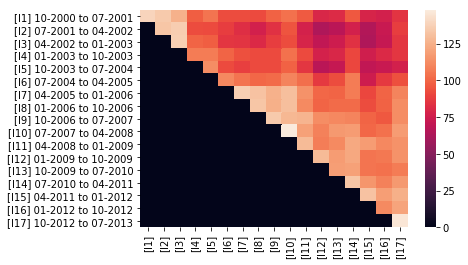

In [119]:
draw_heatmap(allchi2[0].pivot(columns='test_interval', index='train_interval', values='num_of_h0').fillna(0))

The conclusion is that there is a difference between the first years of the dataset (until 2003) and the last years (before 2003). Furthermore, as expected, there are more similarities in the diagonal, which represent consecutive intervals.

We can look at one of the attributes in detail to see how can these results be interpreted. For instance, let's have a look to Resource 825

In [ ]:
tcs = el.TimeCaseSplit(train_size=pd.DateOffset(months=9), train_freq=pd.DateOffset(months=9), test_freq=pd.DateOffset(months=9), test_periods=50, threshold=100, sliding=True)
resource825_sum, resource825_detail = compute_all_chi2(X.loc[:,['Resource_825.0']], tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]),verbose=True)

In [ ]:
sns.heatmap(resource825_sum.pivot(index='train_interval', columns='test_interval', values='num_of_h0').fillna(-1))

The conclusion is that there is no difference in the dataset since 2004. If we look into the details, we see that this resource stop appearing in the process in 2004. Actually, this coincides with the gap that we detected in the process in that year.

# RQ2: Does time have an influence on the quality of the models?
To answer this question, we are going to analyse the evolution of model performance using the first two strategies (new models each time and updating a model that includes all information):

In [44]:
from experiments import run_experiment_classifier, run_experiment_classifier_voting, compare_diag, compute_weights, shape_summary
from splitters import TimeCaseSplit

def launch_experiment_rq2(months_size, months_freq, months_test):
    tcs = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsV = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=True)
    tcsF = TimeCaseSplit(train_size=pd.DateOffset(months=months_size), train_freq=pd.DateOffset(months=months_freq), test_freq=pd.DateOffset(months=months_test), test_periods=40, threshold=700, sliding=False)
    print('Starting X')
    summary_X= run_experiment_classifier(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment_classifier(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    summary_X_V = run_experiment_classifier_voting(X, y, tcsV.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
        
    return summary_X, summary_X_F, summary_X_V

def launch_experiment_rolling(size, freq, window, steps, datasets=range(0,5)):
    tcs = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_freq=freq, threshold=500,sliding=False)
    print('Starting X')
    summary_X= run_experiment_classifier_y(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]),window, steps, summary_class='regular')
    print('Starting X_F')
    summary_X_F = run_experiment_classifier_y(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), window, steps,summary_class='regular')
        
    return summary_X, summary_X_F, summary_X_V


def launch_experiment_number(size, freq, test, datasets=range(0,5)):
    tcs = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20,threshold=500,  sliding=True)
    tcsV = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=True)
    tcsF = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=False)
    tcsS = NumberCaseSplit(train_size=size, train_freq=freq, test_freq=test, test_periods=20, threshold=500,sliding=False, sampling=True)
    print('Starting X_S')
    summary_X_S = run_experiment_classifier(X, y, tcsS.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X')
    summary_X = run_experiment_classifier(X, y, tcs.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_F')
    summary_X_F =run_experiment_classifier(X, y, tcsF.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    print('Starting X_V')
    summary_X_V= run_experiment_classifier_voting(X, y, tcsV.split(X,y,log.df[log.id_column], log.df[log.timestamp_column]), summary_class='regular')
    
    return summary_X, summary_X_F, summary_X_V, summary_X_S
        

In [75]:
summary_999 = launch_experiment_rq2(9,9,9)

Starting X
Starting X_F
Starting X_V


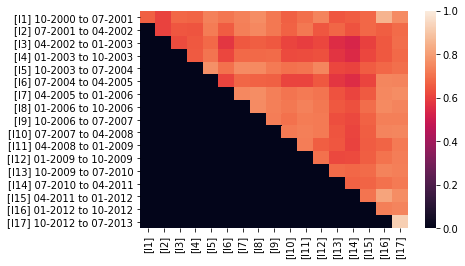

In [91]:
from experiments import shape_summary
draw_heatmap(shape_summary(summary_999[1]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)

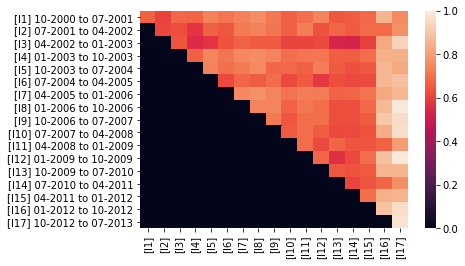

In [93]:
draw_heatmap(shape_summary(summary_999[0]).fillna(0).xs('f1-score',axis=1,drop_level=True),vmax=1)

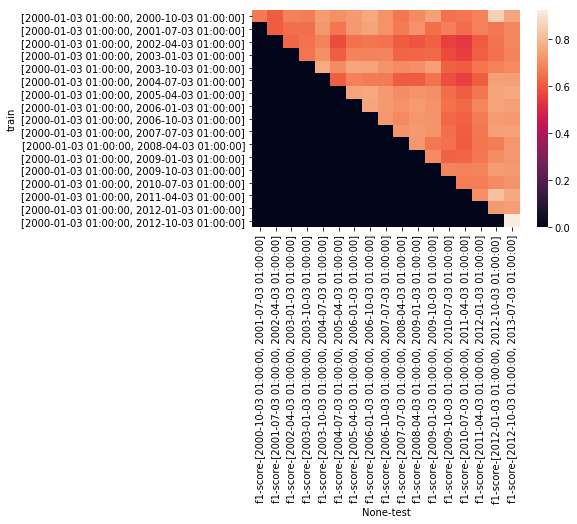

In [64]:
sns.heatmap(shape_summary(summary_9_F_r).fillna(0))

In [45]:
summary_n, summary_n_F, summary_n_V, summary_n_S = launch_experiment_number(8641,4320,4320)

Starting X_S
Sampling from: 8641 in 1
Sampling from: 12961 in 2
Sampling from: 17281 in 3
Sampling from: 21601 in 4
Sampling from: 25921 in 5
Sampling from: 30241 in 6
Sampling from: 34561 in 7
Sampling from: 38881 in 8
Sampling from: 43201 in 9
Sampling from: 47521 in 10
Sampling from: 51841 in 11
Sampling from: 56161 in 12
Sampling from: 60481 in 13
Sampling from: 64801 in 14
Sampling from: 69121 in 15
Sampling from: 73441 in 16
Sampling from: 77761 in 17
Sampling from: 82081 in 18
Sampling from: 86401 in 19
Sampling from: 90721 in 20
Sampling from: 95041 in 21
Sampling from: 99361 in 22
Sampling from: 103681 in 23
Sampling from: 108001 in 24
Sampling from: 112321 in 25
Sampling from: 116641 in 26
Sampling from: 120961 in 27
Sampling from: 125281 in 28
Sampling from: 129601 in 29
Sampling from: 129614 in 30
Starting X
Starting X_F
Starting X_V


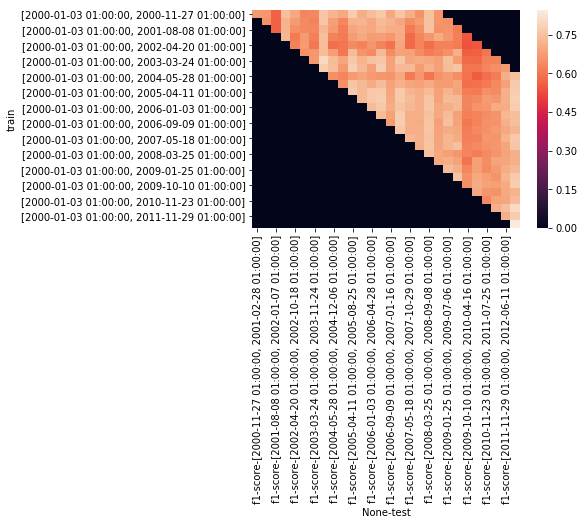

In [83]:
sns.heatmap(shape_summary(summary_n_F).fillna(0))

# RQ3: How does the different update strategies compare against each other?

Finally, we compute execute the experiment for all types of strategies. The final value is the mean of the F-Scores in the diagonal of the matrix obtained.

In [100]:
summary_n_all = [summary_n, summary_n_F, summary_n_V, summary_n_S]

In [103]:
def extract_values(summary, step = 0):
    mask = summary[0].sort_values(['train','test']).groupby('train').cumcount() <= step
    return pd.concat([summary[i][mask]['f1-score'] for i in range(len(summary))],axis=1)

In [105]:
summary_n_fscore = extract_values(summary_n_all)
summary_n_fscore.columns = ['X','F','V','S']


In [112]:
summary_n_fscore.mean()

X    0.694372
F    0.703657
V    0.714230
S    0.705357
dtype: float64

Here, we use the T-test related to check whether there is a significant difference between each column. The result is that only the difference between 'V' and 'X is statistically significant.

In [121]:
from scipy import stats
[(i,j,stats.ttest_rel(summary_n_fscore[i], summary_n_fscore[j])) for ii,i in enumerate(summary_n_fscore.columns) for jj,j in enumerate(summary_n_fscore.columns) if i < j]

[('F',
  'X',
  Ttest_relResult(statistic=1.2527671941138439, pvalue=0.22103241726995335)),
 ('F',
  'V',
  Ttest_relResult(statistic=-1.3650320688729325, pvalue=0.18351044883548195)),
 ('F',
  'S',
  Ttest_relResult(statistic=-0.46362856787053, pvalue=0.6466298815649716)),
 ('V',
  'X',
  Ttest_relResult(statistic=3.1507531132969744, pvalue=0.003957876483001759)),
 ('S',
  'X',
  Ttest_relResult(statistic=1.6928052455530407, pvalue=0.10200215288924347)),
 ('S',
  'V',
  Ttest_relResult(statistic=-1.1216114246414404, pvalue=0.27190415125728346))]